In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
import importlib
from scipy import stats 

import torch
import torch.cuda
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F 

import matplotlib.colors as clr

In [2]:
import dataset_predict
importlib.reload(dataset_predict)

import LegNet # LegNet-Generator
import model # LegNet-Predictor

/home/kekulen/.miniconda3/envs/deepl/lib/python3.9/site-packages/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


## loading a dataset of random sequences

In [3]:
batch_size = 1024*4
num_workers = 8
batch_per_epoch = 1
device= torch.device('cuda:0')

PATH_FROM = 'path_to_random_sequense' 

df = pd.read_csv(PATH_FROM, sep= '\t')

my_df = dataset_predict.PromotersData(df)
my_df.data

,seq,expression
0,AATTTTTTTAGCGCCCGATCCCTTAAGACTAAGGATTGTGCGTCCT...,13
1,TAAGAACGGTGCTGGTTTCGATGTTTAAACACCCTTGAGCACGTAC...,11
2,TTCACTAGGATCCCTAACGACCTTTAGCGACTGGCGACCGATATAT...,15
3,GCTGTGATAGTAGCTACCCGCTTTTGTAGGGTCTTAGAAGGGGGTT...,6
4,CGAGGGGTCTACGGCGGAAAGCCCCAAACACCCAGTCACACATGGT...,13
...,...,...
5999995,ATATGTTTGGCTGACTGAAGTTGGCCACGGACATGCTTATAGCGAG...,4
5999996,GAATGCAAATCGGTTTATGATGTCCGACCTGATGTAGATATTTGTT...,4
5999997,GACCAGTATACCCCACTGTTTAGTGTCCATGCCGCTTCTAGCCGCA...,10
5999998,CGCGATACAAACCCCGCAAACTATCCTGCGAAACTCTCGGAAAATT...,15


## Data preprocessing

In [4]:
def preprocess_data(data, length):
    PLASMID = "aactctcaaggatcttaccgctgttgagatccagttcgatgtaacccactcgtgcacccaactgatcttcagcatcttttactttcaccagcgtttctgggtgagcaaaaacaggaaggcaaaatgccgcaaaaaagggaataagggcgacacggaaatgttgaatactcatactcttcctttttcaatattattgaagcatttatcagggttattgtctcatgagcggatacatatttgaatgtatttagaaaaataaacaaataggggttccgcgcacatttccccgaaaagtgccacctgacgtcatctatattaccctgttatccctagcggatctgccggtagaggtgtggtcaataagagcgacctcatactatacctgagaaagcaacctgacctacaggaaagagttactcaagaataagaattttcgttttaaaacctaagagtcactttaaaatttgtatacacttattttttttataacttatttaataataaaaatcataaatcataagaaattcgcttatttagaagtGGCGCGCCGGTCCGttacttgtacagctcgtccatgccgccggtggagtggcggccctcggcgcgttcgtactgttccacgatggtgtagtcctcgttgtgggaggtgatgtccaacttgatgttgacgttgtaggcgccgggcagctgcacgggcttcttggccttgtaggtggtcttgacctcagcgtcgtagtggccgccgtccttcagcttcagcctctgcttgatctcgcccttcagggcgccgtcctcggggtacatccgctcggaggaggcctcccagcccatggtcttcttctgcattacggggccgtcggaggggaagttggtgccgcgcagcttcaccttgtagatgaactcgccgtcctgcagggaggagtcctgggtcacggtcaccacgccgccgtcctcgaagttcatcacgcgctcccacttgaagccctcggggaaggacagcttcaagtagtcggggatgtcggcggggtgcttcacgtaggccttggagccgtacatgaactgaggggacaggatgtcccaggcgaagggcagggggccacccttggtcaccttcagcttggcggtctgggtgccctcgtaggggcggccctcgccctcgccctcgatctcgaactcgtggccgttcacggagccctccatgtgcaccttgaagcgcatgaactccttgatgatggccatgttatcctcctcgcccttgctcacCATGGTACTAGTGTTTAGTTAATTATAGTTCGTTGACCGTATATTCTAAAAACAAGTACTCCTTAAAAAAAAACCTTGAAGGGAATAAACAAGTAGAATAGATAGAGAGAAAAATAGAAAATGCAAGAGAATTTATATATTAGAAAGAGAGAAAGAAAAATGGAAAAAAAAAAATAGGAAAAGCCAGAAATAGCACTAGAAGGAGCGACACCAGAAAAGAAGGTGATGGAACCAATTTAGCTATATATAGTTAACTACCGGCTCGATCATCTCTGCCTCCAGCATAGTCGAAGAAGAATTTTTTTTTTCTTGAGGCTTCTGTCAGCAACTCGTATTTTTTCTTTCTTTTTTGGTGAGCCTAAAAAGTTCCCACGTTCTCTTGTACGACGCCGTCACAAACAACCTTATGGGTAATTTGTCGCGGTCTGGGTGTATAAATGTGTGGGTGCAACATGAATGTACGGAGGTAGTTTGCTGATTGGCGGTCTATAGATACCTTGGTTATGGCGCCCTCACAGCCGGCAGGGGAAGCGCCTACGCTTGACATCTACTATATGTAAGTATACGGCCCCATATATAggccctttcgtctcgcgcgtttcggtgatgacggtgaaaacctctgacacatgcagctcccggagacggtcacagcttgtctgtaagcggatgccgggagcagacaagcccgtcagggcgcgtcagcgggtgttggcgggtgtcggggctggcttaactatgcggcatcagagcagattgtactgagagtgcaccatatggacatattgtcgttagaacgcggctacaattaatacataaccttatgtatcatacacatacgatttaggtgacactatagaacgcggccgccagctgaagctttaactatgcggcatcagagcagattgtactgagagtgcaccataccaccttttcaattcatcattttttttttattcttttttttgatttcggtttccttgaaatttttttgattcggtaatctccgaacagaaggaagaacgaaggaaggagcacagacttagattggtatatatacgcatatgtagtgttgaagaaacatgaaattgcccagtattcttaacccaactgcacagaacaaaaacctgcaggaaacgaagataaatcatgtcgaaagctacatataaggaacgtgctgctactcatcctagtcctgttgctgccaagctatttaatatcatgcacgaaaagcaaacaaacttgtgtgcttcattggatgttcgtaccaccaaggaattactggagttagttgaagcattaggtcccaaaatttgtttactaaaaacacatgtggatatcttgactgatttttccatggagggcacagttaagccgctaaaggcattatccgccaagtacaattttttactcttcgaagacagaaaatttgctgacattggtaatacagtcaaattgcagtactctgcgggtgtatacagaatagcagaatgggcagacattacgaatgcacacggtgtggtgggcccaggtattgttagcggtttgaagcaggcggcagaagaagtaacaaaggaacctagaggccttttgatgttagcagaattgtcatgcaagggctccctatctactggagaatatactaagggtactgttgacattgcgaagagcgacaaagattttgttatcggctttattgctcaaagagacatgggtggaagagatgaaggttacgattggttgattatgacacccggtgtgggtttagatgacaagggagacgcattgggtcaacagtatagaaccgtggatgatgtggtctctacaggatctgacattattattgttggaagaggactatttgcaaagggaagggatgctaaggtagagggtgaacgttacagaaaagcaggctgggaagcatatttgagaagatgcggccagcaaaactaaaaaactgtattataagtaaatgcatgtatactaaactcacaaattagagcttcaatttaattatatcagttattaccctatgcggtgtgaaataccgcacagatgcgtaaggagaaaataccgcatcaggaaattgtaagcgttaatattttgttaaaattcgcgttaaatttttgttaaatcagctcattttttaaccaataggccgaaatcggcaaaatcccttataaatcaaaagaatagaccgagatagggttgagtgttgttccagtttggaacaagagtccactattaaagaacgtggactccaacgtcaaagggcgaaaaaccgtctatcagggcgatggcccactacgtgaaccatcaccctaatcaagtGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATTTTTTTCACATCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGTTACGGCTGTTTCTTAATTAAAAAAAGATAGAAAACATTAGGAGTGTAACACAAGACTTTCGGATCCTGAGCAGGCAAGATAAACGAAGGCAAAGatgtctaaaggtgaagaattattcactggtgttgtcccaattttggttgaattagatggtgatgttaatggtcacaaattttctgtctccggtgaaggtgaaggtgatgctacttacggtaaattgaccttaaaattgatttgtactactggtaaattgccagttccatggccaaccttagtcactactttaggttatggtttgcaatgttttgctagatacccagatcatatgaaacaacatgactttttcaagtctgccatgccagaaggttatgttcaagaaagaactatttttttcaaagatgacggtaactacaagaccagagctgaagtcaagtttgaaggtgataccttagttaatagaatcgaattaaaaggtattgattttaaagaagatggtaacattttaggtcacaaattggaatacaactataactctcacaatgtttacatcactgctgacaaacaaaagaatggtatcaaagctaacttcaaaattagacacaacattgaagatggtggtgttcaattagctgaccattatcaacaaaatactccaattggtgatggtccagtcttgttaccagacaaccattacttatcctatcaatctgccttatccaaagatccaaacgaaaagagagaccacatggtcttgttagaatttgttactgctgctggtattacccatggtatggatgaattgtacaaataaggcgcgccacttctaaataagcgaatttcttatgatttatgatttttattattaaataagttataaaaaaaataagtgtatacaaattttaaagtgactcttaggttttaaaacgaaaattcttattcttgagtaactctttcctgtaggtcaggttgctttctcaggtatagtatgaggtcgctcttattgaccacacctctaccggcagatccgctagggataacagggtaatataGATCTGTTTAGCTTGCCTCGTCCCCGCCGGGTCACCCGGCCAGCGACATGGAGGCCCAGAATACCCTCCTTGACAGTCTTGACGTGCGCAGCTCAGGGGCATGATGTGACTGTCGCCCGTACATTTAGCCCATACATCCCCATGTATAATCATTTGCATCCATACATTTTGATGGCCGCACGGCGCGAAGCAAAAATTACGGCTCCTCGCTGCAGACCTGCGAGCAGGGAAACGCTCCCCTCACAGACGCGTTGAATTGTCCCCACGCCGCGCCCCTGTAGAGAAATATAAAAGGTTAGGATTTGCCACTGAGGTTCTTCTTTCATATACTTCCTTTTAAAATCTTGCTAGGATACAGTTCTCACATCACATCCGAACATAAACAACCATGGGTACCACTCTTGACGACACGGCTTACCGGTACCGCACCAGTGTCCCGGGGGACGCCGAGGCCATCGAGGCACTGGATGGGTCCTTCACCACCGACACCGTCTTCCGCGTCACCGCCACCGGGGACGGCTTCACCCTGCGGGAGGTGCCGGTGGACCCGCCCCTGACCAAGGTGTTCCCCGACGACGAATCGGACGACGAATCGGACGACGGGGAGGACGGCGACCCGGACTCCCGGACGTTCGTCGCGTACGGGGACGACGGCGACCTGGCGGGCTTCGTGGTCGTCTCGTACTCCGGCTGGAACCGCCGGCTGACCGTCGAGGACATCGAGGTCGCCCCGGAGCACCGGGGGCACGGGGTCGGGCGCGCGTTGATGGGGCTCGCGACGGAGTTCGCCCGCGAGCGGGGCGCCGGGCACCTCTGGCTGGAGGTCACCAACGTCAACGCACCGGCGATCCACGCGTACCGGCGGATGGGGTTCACCCTCTGCGGCCTGGACACCGCCCTGTACGACGGCACCGCCTCGGACGGCGAGCAGGCGCTCTACATGAGCATGCCCTGCCCCTAATCAGTACTGACAATAAAAAGATTCTTGTTTTCAAGAACTTGTCATTTGTATAGTTTTTTTATATTGTAGTTGTTCTATTTTAATCAAATGTTAGCGTGATTTATATTTTTTTTCGCCTCGACATCATCTGCCCAGATGCGAAGTTAAGTGCGCAGAAAGTAATATCATGCGTCAATCGTATGTGAATGCTGGTCGCTATACTGCTGTCGATTCGATACTAACGCCGCCATCCAGTGTCGAAAACGAGCTCGaattcctgggtccttttcatcacgtgctataaaaataattataatttaaattttttaatataaatatataaattaaaaatagaaagtaaaaaaagaaattaaagaaaaaatagtttttgttttccgaagatgtaaaagactctagggggatcgccaacaaatactaccttttatcttgctcttcctgctctcaggtattaatgccgaattgtttcatcttgtctgtgtagaagaccacacacgaaaatcctgtgattttacattttacttatcgttaatcgaatgtatatctatttaatctgcttttcttgtctaataaatatatatgtaaagtacgctttttgttgaaattttttaaacctttgtttatttttttttcttcattccgtaactcttctaccttctttatttactttctaaaatccaaatacaaaacataaaaataaataaacacagagtaaattcccaaattattccatcattaaaagatacgaggcgcgtgtaagttacaggcaagcgatccgtccGATATCatcagatccactagtggcctatgcggccgcggatctgccggtctccctatagtgagtcgtattaatttcgataagccaggttaacctgcattaatgaatcggccaacgcgcggggagaggcggtttgcgtattgggcgctcttccgcttcctcgctcactgactcgctgcgctcggtcgttcggctgcggcgagcggtatcagctcactcaaaggcggtaatacggttatccacagaatcaggggataacgcaggaaagaacatgtgagcaaaaggccagcaaaaggccaggaaccgtaaaaaggccgcgttgctggcgtttttccataggctccgcccccctgacgagcatcacaaaaatcgacgctcaagtcagaggtggcgaaacccgacaggactataaagataccaggcgtttccccctggaagctccctcgtgcgctctcctgttccgaccctgccgcttaccggatacctgtccgcctttctcccttcgggaagcgtggcgctttctcaTAgctcacgctgtaggtatctcagttcggtgtaggtcgttcgctccaagctgggctgtgtgcacgaaccccccgttcagcccgaccgctgcgccttatccggtaactatcgtcttgagtccaacccggtaagacacgacttatcgccactggcagcagccactggtaacaggattagcagagcgaggtatgtaggcggtgctacagagttcttgaagtggtggcctaactacggctacactagaagAacagtatttggtatctgcgctctgctgaagccagttaccttcggaaaaagagttggtagctcttgatccggcaaacaaaccaccgctggtagcggtggtttttttgtttgcaagcagcagattacgcgcagaaaaaaaggatctcaagaagatcctttgatcttttctacggggtctgacgctcagtggaacgaaaactcacgttaagggattttggtcatgagattatcaaaaaggatcttcacctagatccttttaaattaaaaatgaagttttaaatcaatctaaagtatatatgagtaaacttggtctgacagttaccaatgcttaatcagtgaggcacctatctcagcgatctgtctatttcgttcatccatagttgcctgactccccgtcgtgtagataactacgatacgggagggcttaccatctggccccagtgctgcaatgataccgcgagacccacgTtcaccggctccagatttatcagcaataaaccagccagccggaagggccgagcgcagaagtggtcctgcaactttatccgcctccatccagtctattaattgttgccgggaagctagagtaagtagttcgccagttaatagtttgcgcaacgttgttgccattgctacaggcatcgtggtgtcacgctcgtcgtttggtatggcttcattcagctccggttcccaacgatcaaggcgagttacatgatcccccatgttgtgcaaaaaagcggttagctccttcggtcctccgatcgttgtcagaagtaagttggccgcagtgttatcactcatggttatggcagcactgcataattctcttactgtcatgccatccgtaagatgcttttctgtgactggtgagtactcaaccaagtcattctgagaatagtgtatgcggcgaccgagttgctcttgcccggcgtcaatacgggataataccgcgccacatagcagaactttaaaagtgctcatcattggaaaacgttcttcggggcgaa"
    PLASMID = PLASMID.upper()
    INSERT_START = PLASMID.find('N'*80)
    LEFT_ADAPTER = "TGCATTTTTTTCACATC" 
    RIGHT_ADAPTER = "GGTTACGGCTGTT"
    data = data.copy()
    add_part = PLASMID[INSERT_START-length:INSERT_START]
    data.seq = data.seq.apply(lambda x:  add_part + x[len(LEFT_ADAPTER):])
    data.seq = data.seq.str.slice(-length, None)
    return data

CODES = {
    "A": 0,
    "T": 3,
    "G": 1,
    "C": 2,
    'N': 4
}
RIGHT = 'GGTTACGGCTGTT'
LEFT = 'AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATTTTTTTCACATC'

def n2id(n):
    return CODES[n.upper()]

class Seq2Tensor(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, seq):
        if isinstance(seq, torch.FloatTensor):
            return seq
        seq = [n2id(x) for x in seq]
        code = torch.from_numpy(np.array(seq))
        code = F.one_hot(code, num_classes=5)
        
        code[code[:, 4] == 1] = 0.25
        code = code[:, :4].float()
        return code.transpose(0, 1)

def left_right():
    s2t = Seq2Tensor()
    right_s2t = torch.concat((s2t(RIGHT), torch.zeros(2, s2t(RIGHT).shape[1])))
    left_s2t = torch.concat((s2t(LEFT), torch.zeros(2, s2t(LEFT).shape[1])))
    return right_s2t, left_s2t

def adapter_adder(pred_seq):
    seqs = torch.concat((pred_seq, torch.zeros(pred_seq.shape[0],2,pred_seq.shape[2], device=device)), dim=1)
    right_s2t, left_s2t = left_right()
    left_batch = torch.broadcast_to(left_s2t, (seqs.shape[0], left_s2t.shape[0], left_s2t.shape[1])).to(device)
    right_batch = torch.broadcast_to(right_s2t, (seqs.shape[0], right_s2t.shape[0], right_s2t.shape[1])).to(device)
    temp_pred = torch.concat((left_batch, seqs), dim=2).to(device)
    long_pred = torch.concat((temp_pred, right_batch), dim=2)
    return long_pred
    


In [5]:
# Draw raw correlation plot
def correlation_plot(given_expression, pred_score):
    plt.figure(frameon=False)
    mse = ((given_expression - pred_score) ** 2).mean()
    rmse = ((given_expression - pred_score) ** 2).mean() ** 0.5
    plt.scatter(pred_score, given_expression, alpha=0.1)
    Sp_cor = round(stats.spearmanr(given_expression, pred_score)[0], 3)
    P_cor= round(stats.pearsonr(given_expression, pred_score)[0], 3)
    plt.text(plt.xlim()[1] + 0.25, plt.ylim()[1] - 4,
            f"$\\rho$ = {Sp_cor:.04f}\n" +
            f"r = {P_cor:.04f}\n" +
            f"MSE = {mse:.04f}\n" +
            f"RMSE = {rmse:.04f}\n")
    plt.xlabel('Pred expression')
    plt.ylabel('Target expression')
    plt.show()

    return Sp_cor, P_cor, mse

## Generation procedure

In [6]:
legnet_generator_path = f'../models/generator/model_200.pth'

difussion_model = LegNet.LegNet(80,
                ks=7,
#                 in_channels=7,
                block_sizes=[256, 128, 128, 64, 64, 64, 64],
                final_ch=4).to(device)

difussion_model.load_state_dict(torch.load(legnet_generator_path, map_location=device)['model_state_dict'])
difussion_model.requires_grad_ = False

In [7]:
legnet_predictor_path = '../models/predictor/model_80.pth'
pretraned_model = model.SeqNN(150,
                ks=7,
                use_single_channel=True,
                block_sizes=[256, 128, 128, 64, 64, 64, 64],
                final_ch=18).to(device)

pretraned_model.load_state_dict(torch.load(legnet_predictor_path, map_location=device))
pretraned_model.requires_grad_ = False

In [8]:
all_size = my_df.data.shape[0]
test_size = batch_size
train_size = all_size-test_size
train_set, val_set = torch.utils.data.random_split(my_df, [train_size, test_size])

dl_test = DataLoader(val_set,
                     batch_size=batch_size,
                     num_workers=num_workers,
                     shuffle=False,
                     worker_init_fn = lambda id: np.random.seed(id)
                    )

In [9]:
from itertools import permutations
ALLPERM = torch.tensor(list(permutations((0, 1, 2, 3))))
ALLPERM

# mutation procedure

def mutagenesisv2_(seqs, maxmut):
    batchsize = seqs.shape[0]
    seqlen = seqs.shape[2]
    muts = torch.full((batchsize,), maxmut)
    indexx = torch.arange(batchsize)
    mut_positions = torch.zeros(batchsize, seqlen, dtype=bool)
    for i in range(maxmut):
        single_positions = torch.randint(high=seqlen, size=(batchsize,))
        mut_positions[indexx, single_positions] |= muts > i

    mut_positions = mut_positions[:,None,:].broadcast_to(seqs.shape)
    x = seqs.permute(2, 0, 1)[mut_positions.permute(2, 0, 1)]
    mut_number = x.shape[0] // 4
    
    myperm = torch.randint(high=ALLPERM.shape[0], size=(mut_number,))
    myperm = (ALLPERM[myperm] + torch.arange(mut_number)[:,None] * 4).ravel()
    seqs.permute(2, 0, 1)[mut_positions.permute(2, 0, 1)] = x[myperm]
    

In [1]:
# diffusion-like sampling

def predict_float(dl_test, mut_interval, intensities, start, end):    
    seqs_batches = []
    scores_batches = []
    b_i = 0
    with torch.no_grad():
        difussion_model.eval()
        for data in dl_test:
            b_i += 1
            seq_batch = data.float().to(device)
            score_chanels = seq_batch[:,4:5,:].clone().to(device)
            seq_batch = seq_batch[:,:4,:]
            target_score = torch.FloatTensor(seq_batch.shape[0], 1, 1).uniform_(start, end).to(device)
            for intens, muts, in zip(intensities, mut_interval):
                mutagenesisv2_(seq_batch, muts)              
                tmp = torch.broadcast_to(target_score, (target_score.shape[0], 1, 80))
                seq_batch = torch.concat((seq_batch.to(device), tmp.to(device), torch.full_like(score_chanels, intens).to(device)), dim=1) 
                seq_batch = difussion_model(seq_batch)
                seq_batch = torch.softmax(seq_batch, dim=1) 
            seqs_batches.append(seq_batch.cpu().numpy()) 
            scores_batches.append((target_score.squeeze()).cpu().numpy())
        return seqs_batches, target_score, scores_batches



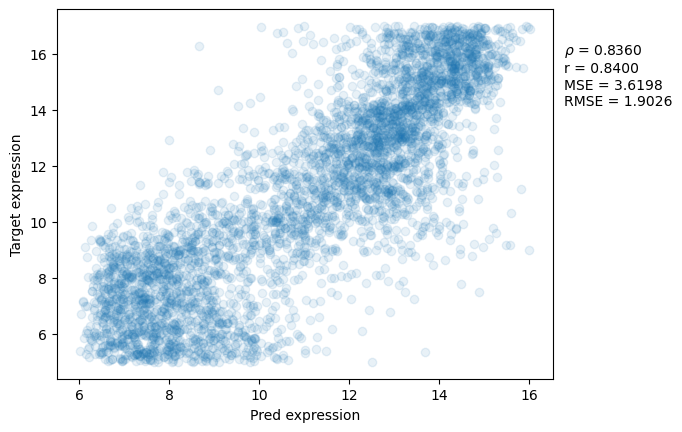

In [11]:
start = 5
end = 17

steps = 100 # (empirically choosen)
m_i_start, m_i_end = 100, 0 # number of introduced mutations (empirically chosen)
in_start, in_end = 130, 30 # number of mutations in channel (empirically chosen)

mut_interval = np.arange(m_i_start, m_i_end, -1).round().astype("int")
intensities = np.arange(in_start, in_end, -1).round().astype("int")


seqs, seqs_batches, scores_batches = predict_float(dl_test, mut_interval, intensities, start, end)

# small raw picture 
given_expression = scores_batches[0]
decoded_seq  = F.one_hot(torch.tensor(seqs[0]).argmax(axis=1)).permute(0, 2, 1).cpu().numpy()
long_pred = adapter_adder(torch.tensor(decoded_seq).to(device)).float()
pretraned_model.eval()
with torch.no_grad():
    pred_score = pretraned_model(long_pred)[1].cpu().numpy() 
mse = ((scores_batches[0] - pred_score) ** 2).mean()
rmse = ((scores_batches[0] - pred_score) ** 2).mean() ** 0.5

Sp_cor, P_cor, mse = correlation_plot(scores_batches[0], pred_score)



-----------